# DUD-E decoys are too similar

If two decoys in different targets have Tc > cutoff, randomly remove one of them.

target|#decoys|#decoys(Tc<0.4)|#decoys(Tc<0.25)
---|---|---
akt1/|  16451|  3831|  47
ampc/|   2850|  1749|  69
cp3a4|  11800|  2071|  91
cxcr4|   3406|  1198|  26
gcr/d|  15000|  3146|  42
hivpr|  35750| 21623|4171
hivrt|  18891| 10292|1873
kif11|   6850|  2938|1029
Total| 110998| **46848 (42.2%)**|**7348 (6.6%)**
mean_AUC_ROC|0.822|0.727|~~0.700~~
mean_EF1%|12.09|5.86|~~1.77~~

Most of test_actives and train_decoys have Tc < 0.4.

Model train on decoys with Tc < 0.4 has worse performance.

Most of acitves and decoys in same target have Tc < 0.25.

Performance on decoys with Tc < 0.25 is not reliable for too less decoys.

```
test_actives --- test_decoys
      |    \_____/     |
      |    /     \     |
train_actives    train_decoys
```
Tc distribution in figures below.

### import common use modules

In [1]:
import os
import sys
import json
import argparse
import numpy as np
import scipy.sparse as sp
from scipy.spatial import distance
import itertools
from multiprocessing import Pool

from rdkit import Chem
from rdkit.Chem import AllChem

from sklearn import metrics
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import matplotlib
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

### Fuctions for DUD-E loading

In [4]:
def mol_to_fp(m):
    # radius 2 MorganFingerprint equal ECFP4
    fp = AllChem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024)
    return fp

def fps2dist(X, Y):
    X = X.toarray().astype(np.bool)
    Y = Y.toarray().astype(np.bool)
    dist = pairwise_distances(X=X, Y=Y, metric="jaccard", n_jobs=-1)
    return dist

def load_smiles(names, datadir='./', dudx=False):
    all_X = []
    all_y = []
    ws = []
    # print("Loading data set ...")
    for name in names:
        file_name = os.path.join(datadir, name)
        activeFile = os.path.join(file_name, 'actives_final.ism')
        if dudx:
            decoyFile = os.path.join(file_name, 'decoys_finalX.ism')
            if not os.path.join(decoyFile):
                print("generate DUDX for target {} by reduce_decoy_similarity().".formt(name))
            Xf = os.path.join(file_name, 'fpX.npz')
            yf = os.path.join(file_name, 'labelX.npz')
        else:
            decoyFile = os.path.join(file_name, 'decoys_final.ism')
            Xf = os.path.join(file_name, 'fp.npz')
            yf = os.path.join(file_name, 'label.npz')
        if os.path.exists(Xf) and os.path.exists(yf):
            fps = sp.load_npz(Xf)
            y = sp.load_npz(yf)
        else:
            # print("Loading smiles {} ...".format(activeFile))
            active = [m for m in Chem.SmilesMolSupplier(activeFile, titleLine=False) if m is not None]
            # print("Loading smiles {} ...".format(decoyFile))
            decoy = [m for m in Chem.SmilesMolSupplier(decoyFile, titleLine=False) if m is not None]
            y = sp.csr_matrix(np.hstack((np.ones(len(active)), np.zeros(len(decoy)))))
            ms = np.hstack((active, decoy))
            # print("Computing figerprints ...")
            with Pool() as p:
                fps = sp.csr_matrix(p.map(mol_to_fp, ms))
            #names = np.array([m.GetProp('_Name') for m in ms])
            sp.save_npz(Xf, fps)
            sp.save_npz(yf, y)
        y = np.ravel(y.toarray())
        all_X.append(fps)
        all_y.append(y)
    X = sp.vstack(all_X)
    y = np.hstack(all_y)
    return X, y

def reduce_decoy_similarity(targets, datadir='./', max_simi=0.4):
    remove_idx = [None for i in range(len(targets))]
    for i, ti in enumerate(targets):
        print("{:3d}/{} {:7s}".format(i+1, len(targets), ti), end='\r')
        for j, tj in enumerate(targets):
            if j >= i: continue
            Xi, yi = load_smiles([ti], datadir=datadir)
            Xj, yj = load_smiles([tj], datadir=datadir)
            di = Xi[yi==0]
            dj = Xj[yj==0]
            if remove_idx[i] is None:
                remove_idx[i] = np.zeros(di.shape[0], dtype=np.bool)
            if remove_idx[j] is None:
                remove_idx[j] = np.zeros(dj.shape[0], dtype=np.bool)
            simi_didj = 1. - fps2dist(di, dj)
            simi_didj[remove_idx[i], :] = 0.
            simi_didj[:, remove_idx[j]] = 0.
            mask_didj = simi_didj > max_simi
            for pi, pj in zip(*np.nonzero(mask_didj)):
                if remove_idx[i][pi] or remove_idx[j][pj]:
                    continue
                else:
                    if np.random.rand() < 0.5:
                        remove_idx[i][pi] = True
                    else:
                        remove_idx[j][pj] = True

    for i, ti in enumerate(targets):
        rm_i = remove_idx[i]
        file_name = os.path.join(datadir, ti)
        decoyFile = os.path.join(file_name, 'decoys_final.ism')
        decoyFileX = os.path.join(file_name, 'decoys_finalX.ism')
        Xf = os.path.join(file_name, 'fpX.npz')
        yf = os.path.join(file_name, 'labelX.npz')
        decoy = [m for m in Chem.SmilesMolSupplier(decoyFile, titleLine=False) if m is not None]
        smi = Chem.SmilesWriter(decoyFileX, includeHeader=False)
        for mask, m in zip(rm_i, decoy):
            if mask == False: # not remove
                smi.write(m)
        print("remove {:5d} decoys from target {:6s} ".format(sum(rm_i), ti), end='')
        print("write {:5d} decoys in {}".format(sum(~rm_i), decoyFileX))
        smi.close()
        Xi, yi = load_smiles([ti], datadir=datadir)
        ai = Xi[yi==1]
        di = Xi[yi==0]
        di = di[~rm_i]
        y = sp.csr_matrix(np.hstack((np.ones(ai.shape[0]), np.zeros(di.shape[0]))))
        X = sp.vstack((ai,di))
        sp.save_npz(Xf, X)
        sp.save_npz(yf, y)

### Fingerprint distance and similarity

In [5]:
def jaccard(a,b):
    ab = a.dot(b.T)[0,0]
    return  1.0 - ab / (a.sum()+b.sum()-ab)

def closest(targetI, targetJ, ax=None, decoy_times=None, decoy_ax=None, dudx=False):
    """get targetI active-decoy most similar: max_ad.
    targetI-targetJ active-active most similar: max_aa.
    targetI-targetJ decoy-decoy most similar: max_dd.
    """
    print("test:{}-train:{}".format(targetI, targetJ))
    max_ad = []
    for i, ti in enumerate(targetI):
        fpi, yi = load_smiles([ti], datadir=data_dir, dudx=dudx)
        ai = fpi[yi==1]
        max_aid = []
        for j, tj in enumerate(targetI):
            fpj,yj = load_smiles([tj], datadir=data_dir, dudx=dudx)
            dj = fpj[yj==0]
            dist_aidi = 1. - fps2dist(ai, dj)
            max_aidi = dist_aidi.max(axis=1)
            max_aid.append(max_aidi)
        max_ad.append(np.max(max_aid, axis=0))
    adlist = np.hstack(max_ad)
    sns.kdeplot(adlist, label="test_active-decoy_test",  color='k', ax=ax)
    if decoy_ax:
        sns.kdeplot(adlist, label="test_active-decoy_test",  color='k', ax=decoy_ax)
    max_aa = []
    max_dd = []
    max_ad = []
    max_da = []
    # need max_aa and max_dd with increase targetJ, so targetJ first.
    for j, tj in enumerate(targetJ):
        fpj, yj = load_smiles([tj], datadir=data_dir, dudx=dudx)
        aj = fpj[yj==1]
        dj = fpj[yj==0]
        if decoy_times:
            dj = dj[np.random.choice(dj.shape[0], int(aj.shape[0] * decoy_times))]
        max_aaj = []
        max_ddj = []
        max_adj = []
        max_daj = []
        for i, ti in enumerate(targetI):
            fpi,yi = load_smiles([ti], datadir=data_dir, dudx=dudx)
            ai = fpi[yi==1]
            di = fpi[yi==0]
            if decoy_times:
                di = di[np.random.choice(di.shape[0], int(ai.shape[0] * decoy_times))]
            dist_aiaj = 1. - fps2dist(ai, aj)
            max_aiaj = dist_aiaj.max(axis=1)
            max_aaj.append(max_aiaj)
            dist_didj = 1. - fps2dist(di, dj)
            max_didj = dist_didj.max(axis=1)
            max_ddj.append(max_didj)
            dist_aidj = 1. - fps2dist(ai, dj)
            max_aidj = dist_aidj.max(axis=1)
            max_adj.append(max_aidj)
            dist_diaj = 1. - fps2dist(di, aj)
            max_diaj = dist_diaj.max(axis=1)
            max_daj.append(max_diaj)
        max_aa.append(np.hstack(max_aaj))
        max_dd.append(np.hstack(max_ddj))
        max_ad.append(np.hstack(max_adj))
        max_da.append(np.hstack(max_daj))
    if decoy_ax:
        # show decoy-decoy with increment train targets
        decoy_ax.set_title("test:{}-train (incremental)".format(targetI))
        decoy_ax.set_xlabel("Tanimoto coefficient of most similar test-train compound pairs")
        decoy_ax.set_ylabel("Density")
        decoy_ax.set_ylim(0,15)
        decoy_ax.set_xlim(0,1)
        max_dd = np.array(max_dd)
        for j, tj  in enumerate(targetJ):
            ddlist = np.max(max_dd[:j+1], axis=0)
            sns.kdeplot(ddlist,
                        label="test_decoy-decoy_train +[{}]".format(tj), ax=decoy_ax)
    aalist = np.max(max_aa, axis=0)
    adlist = np.max(max_ad, axis=0)
    dalist = np.max(max_da, axis=0)
    ddlist = np.max(max_dd, axis=0)
    sns.kdeplot(aalist, label="test_active-active_train", ax=ax)
    sns.kdeplot(adlist, label="test_active-decoy_train", ax=ax)
    sns.kdeplot(dalist, label="test_decoy-active_train", ax=ax)
    sns.kdeplot(ddlist, label="test_decoy-decoy_train", ax=ax)
    ax.set_title("test:{}-train:{}".format(targetI, targetJ))
    ax.set_xlabel("Tanimoto coefficient of most similar test-train compound pairs")
    ax.set_ylabel("Density")
    ax.set_ylim(0,15)
    ax.set_xlim(0,1)
    return fig

### Load diverse subset (8 targets) of DUD-E

In [6]:
data_dir="./all"
fold_file="./2split/diverse.json"
with open(fold_file) as f:
    folds = json.load(f)
    if type(folds) is list:
        folds = {i:fold for i,fold in enumerate(folds)}
targets = [i for k, fold in folds.items() for i in fold]
print(targets)

['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']


In [7]:
reduce_decoy_similarity(targets, datadir='all', max_simi=0.4)

remove 12618 decoys from target akt1   write  3832 decoys in all/akt1/decoys_finalX.ism
remove  1101 decoys from target ampc   write  1749 decoys in all/ampc/decoys_finalX.ism
remove  9729 decoys from target cp3a4  write  2071 decoys in all/cp3a4/decoys_finalX.ism
remove  2208 decoys from target cxcr4  write  1198 decoys in all/cxcr4/decoys_finalX.ism
remove 11853 decoys from target gcr    write  3146 decoys in all/gcr/decoys_finalX.ism
remove 14127 decoys from target hivpr  write 21623 decoys in all/hivpr/decoys_finalX.ism
remove  8599 decoys from target hivrt  write 10292 decoys in all/hivrt/decoys_finalX.ism
remove  3912 decoys from target kif11  write  2938 decoys in all/kif11/decoys_finalX.ism


test:['akt1']-train:['ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['ampc']-train:['akt1', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['cp3a4']-train:['akt1', 'ampc', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['cxcr4']-train:['akt1', 'ampc', 'cp3a4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['gcr']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'hivpr', 'hivrt', 'kif11']
test:['hivpr']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivrt', 'kif11']
test:['hivrt']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'kif11']
test:['kif11']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt']


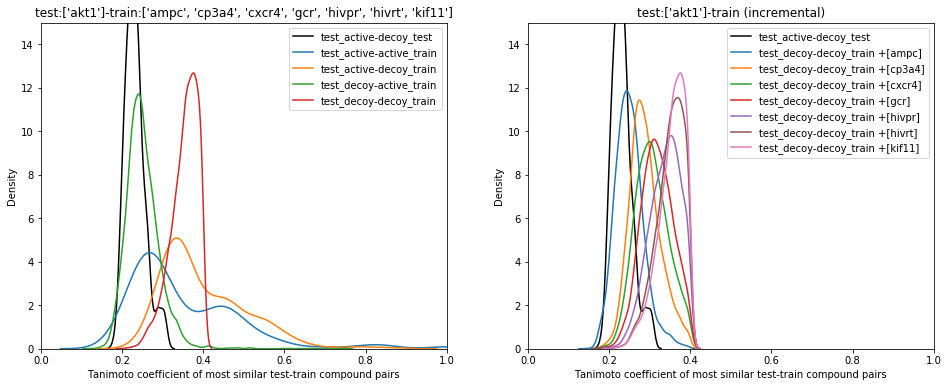

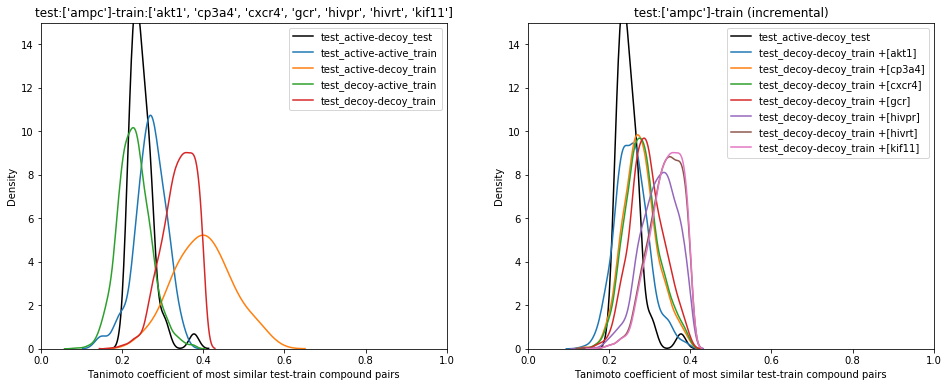

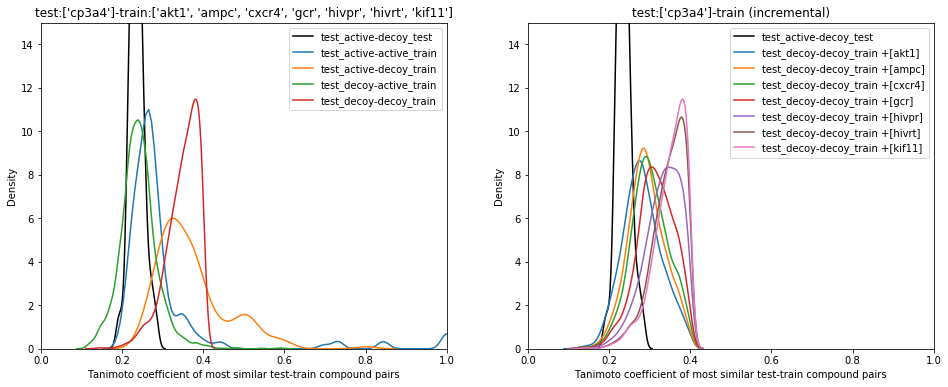

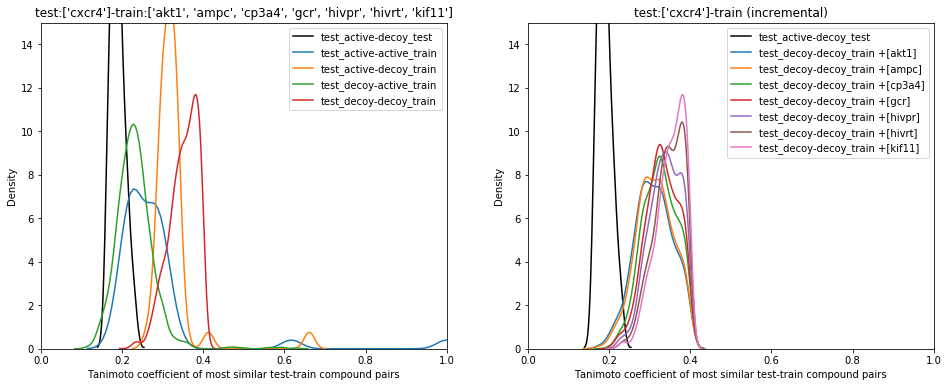

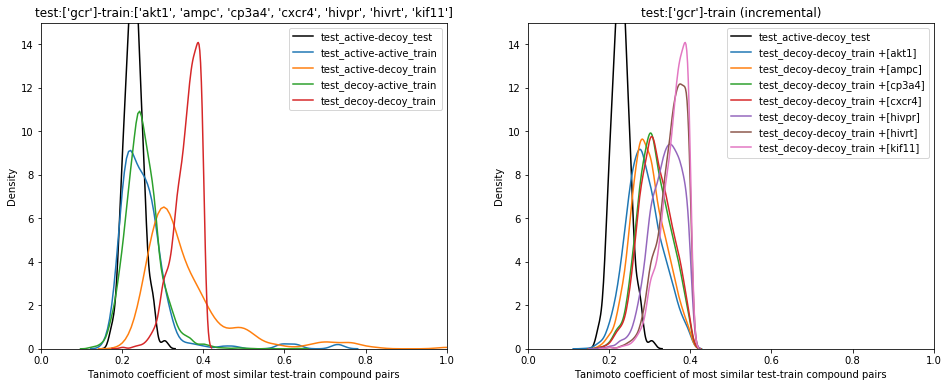

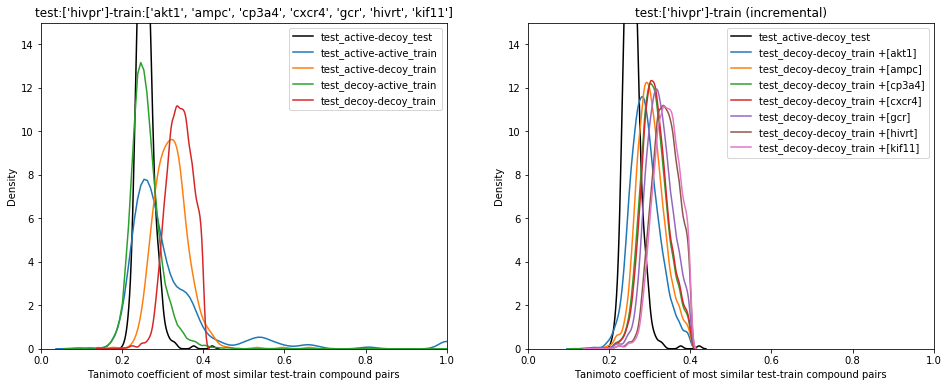

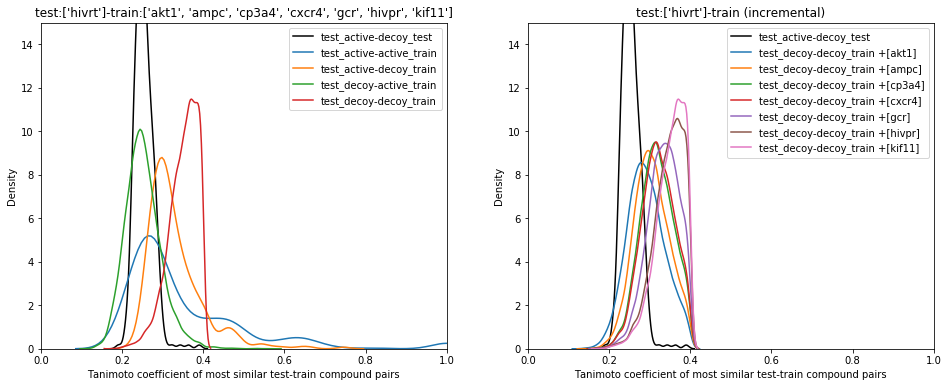

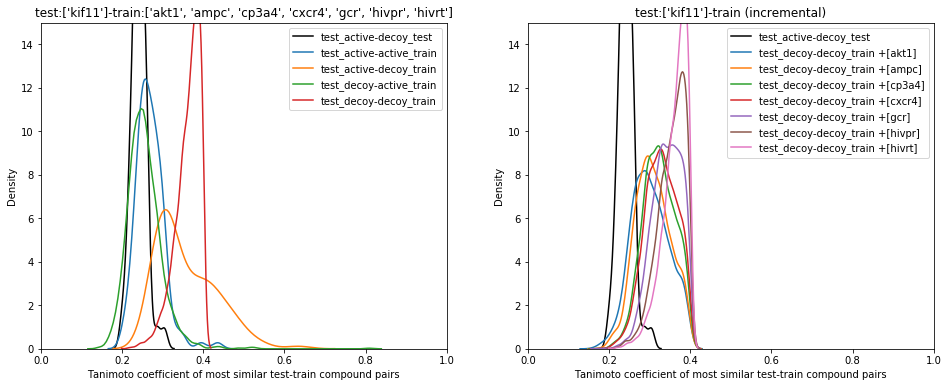

In [9]:
# decoy simi <= 0.4
for i in targets:
    js = []
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax, decoy_ax = axes
    js = [j for j in targets if j != i]
    closest([i], js, ax=ax, decoy_ax=decoy_ax, dudx=True)

In [10]:
reduce_decoy_similarity(targets, datadir='all', max_simi=0.25)

remove 16403 decoys from target akt1   write    47 decoys in all/akt1/decoys_finalX.ism
remove  2781 decoys from target ampc   write    69 decoys in all/ampc/decoys_finalX.ism
remove 11709 decoys from target cp3a4  write    91 decoys in all/cp3a4/decoys_finalX.ism
remove  3380 decoys from target cxcr4  write    26 decoys in all/cxcr4/decoys_finalX.ism
remove 14957 decoys from target gcr    write    42 decoys in all/gcr/decoys_finalX.ism
remove 31579 decoys from target hivpr  write  4171 decoys in all/hivpr/decoys_finalX.ism
remove 17018 decoys from target hivrt  write  1873 decoys in all/hivrt/decoys_finalX.ism
remove  5821 decoys from target kif11  write  1029 decoys in all/kif11/decoys_finalX.ism


test:['akt1']-train:['ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['ampc']-train:['akt1', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['cp3a4']-train:['akt1', 'ampc', 'cxcr4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['cxcr4']-train:['akt1', 'ampc', 'cp3a4', 'gcr', 'hivpr', 'hivrt', 'kif11']
test:['gcr']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'hivpr', 'hivrt', 'kif11']
test:['hivpr']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivrt', 'kif11']
test:['hivrt']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'kif11']
test:['kif11']-train:['akt1', 'ampc', 'cp3a4', 'cxcr4', 'gcr', 'hivpr', 'hivrt']


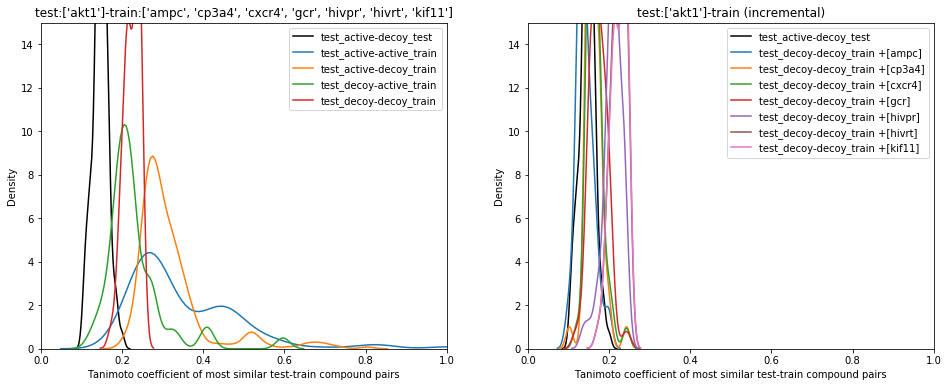

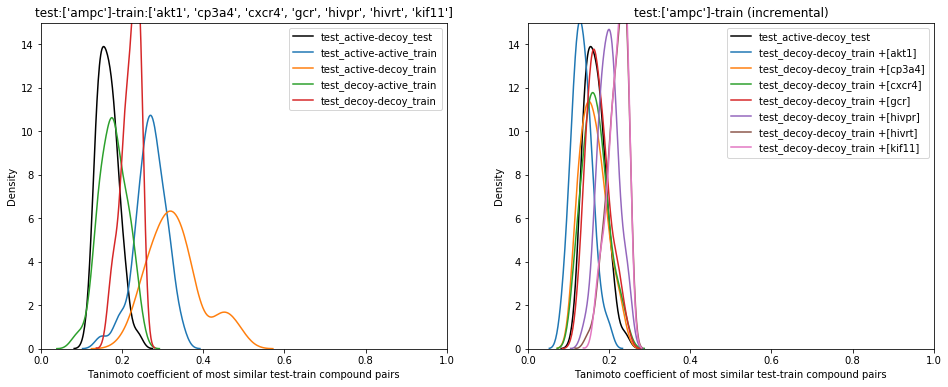

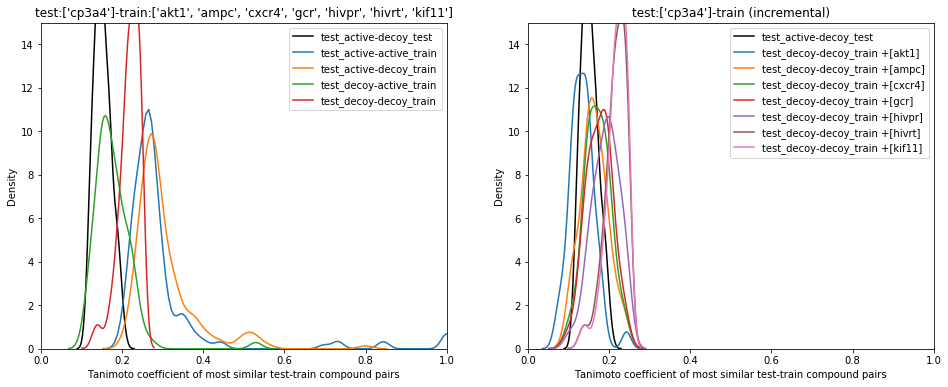

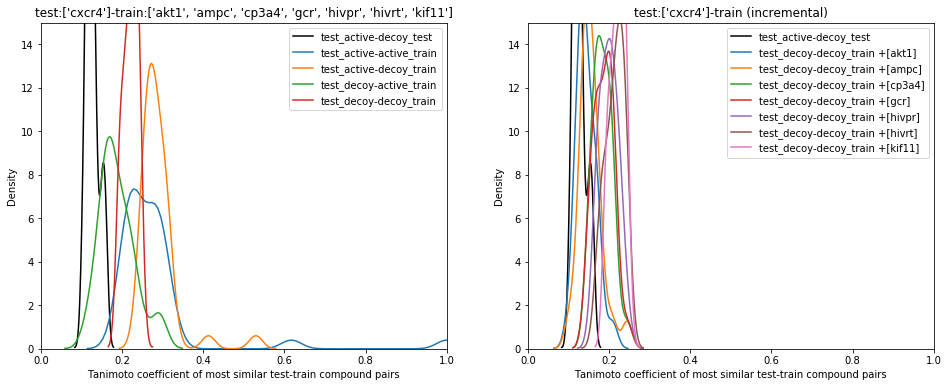

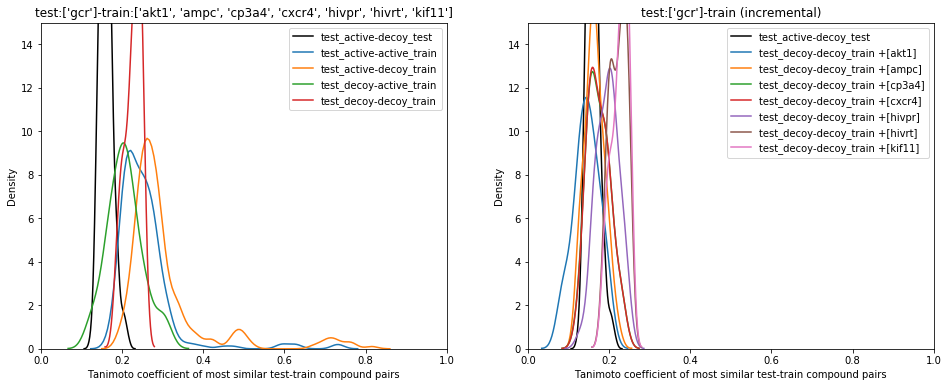

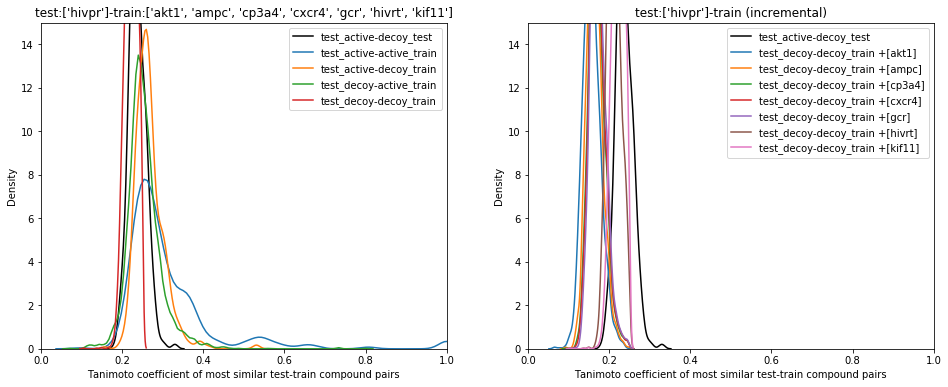

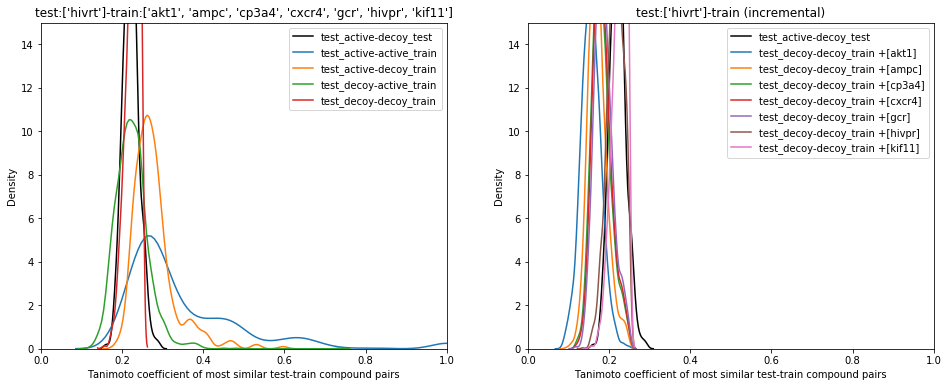

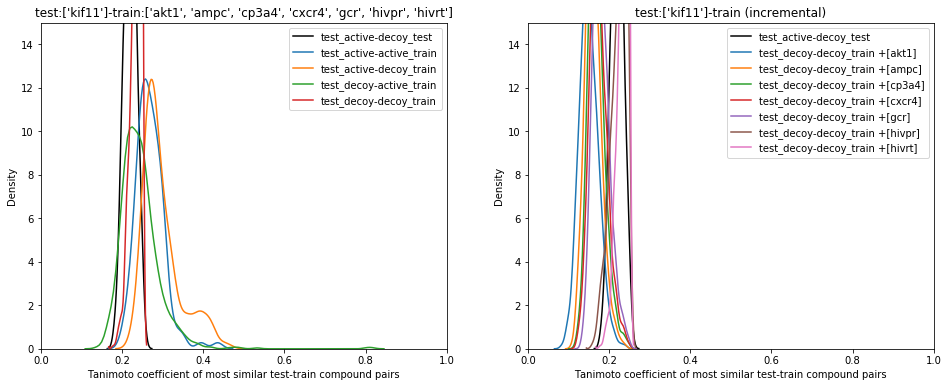

In [11]:
# decoy simi <= 0.25
for i in targets:
    js = []
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    ax, decoy_ax = axes
    js = [j for j in targets if j != i]
    closest([i], js, ax=ax, decoy_ax=decoy_ax, dudx=True)